In [1]:
input_dir = "input/"
images_dir = "sub_images/positive/"

nb_folds = 5
seed = 2024

print(nb_folds, seed)

!ls $input_dir
!ls $images_dir | wc

5 2024
butterfly_anomaly_train_checksums.csv  butterfly_anomaly_train_log.jsonl
butterfly_anomaly_train.csv	       images
   7598    7598  116835


In [2]:
import numpy as np
import pandas as pd
import pickle
import glob

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
np.bool = bool

from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mine
from GCForest import gcForest # https://github.com/pylablanche/gcForest/tree/master
import utils
utils.seed_basic(seed)

!python --version

Python 3.9.21


In [3]:
filenames = glob.glob(images_dir + "/*.jpg")
print(len(filenames), filenames[:2], filenames[-2:])

original_filenames = glob.glob(input_dir + "images/**/*.jpg")
print(len(original_filenames), original_filenames[:2], original_filenames[-2:])

def get_butterfly_id(f):
    return f.split("/")[-1].split(".")[0].split("_")[0]
    
dict_original_filenames = {get_butterfly_id(f):f for f in original_filenames}

def get_original_filename(filename):
    butterfly_id = get_butterfly_id(filename)
    return dict_original_filenames.get(butterfly_id)

get_original_filename('sub_images/positive/CAM016787_3.jpg')

7598 ['sub_images/positive/CAM016787_3.jpg', 'sub_images/positive/19N2282_3.jpg'] ['sub_images/positive/CAM008980_0.jpg', 'sub_images/positive/19N0834_0.jpg']
2082 ['../input/images/hybrid/CAM016787.jpg', '../input/images/hybrid/CAM016987.jpg'] ['../input/images/non-hybrid/CAM016081.jpg', '../input/images/non-hybrid/CAM045121.jpg']


'../input/images/hybrid/CAM016787.jpg'

In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
import numpy as np

def evaluate_prediction(scores, labels, reversed=False):
    combined = list(zip(scores, labels))
    combined = sorted(combined, key=lambda x: x[0], reverse=reversed)
    combined = np.array(combined)

    for i in range(combined.shape[0] + 1):
        ls, rs = i, combined.shape[0] - i
        preds = np.concatenate((np.zeros(ls), np.ones(rs)))
        recall = recall_score(combined[:, 1], preds, pos_label=0)
        if recall >= 0.95:
            return preds, combined[:, 1]
    
    return None, combined[:, 1]  

def evaluate(scores, labels, reversed=False):
    """Requires lower score to mean more likely to be non-hybrid,
    and higher score to mean more likely to be hybrid.
    
    If you would like this to be reversed, set reversed=True
    """
    preds, gt = evaluate_prediction(scores, labels, reversed)

    if preds is None:
        return None  
    
    h_recall = recall_score(gt, preds, pos_label=1)
    h_precision = precision_score(gt, preds, pos_label=1)
    f1 = f1_score(gt, preds, pos_label=1)
    roc_auc = roc_auc_score(gt, preds)
    acc = accuracy_score(gt, preds)

    return h_recall, h_precision, f1, roc_auc, acc

def print_evaluation(h_recall, h_precision, f1, roc_auc, acc):
    print(f"""
          Hybrid-Recall: {h_recall}
          Hybrid-Precision: {h_precision}
          f1-Score: {f1}
          ROC AUC: {roc_auc}
          Accuracy: {acc}
          """)

In [5]:
df_labels = pd.read_csv(input_dir + "butterfly_anomaly_train.csv")
df_labels["butterfly_id"] = df_labels["filename"].apply(lambda f: get_butterfly_id(f))
df_labels.tail()

,CAMID,file_url,hybrid_stat,split,zenodo_link,md5,subspecies,parent_subspecies_1,parent_subspecies_2,filename,butterfly_id
2077,CAM036201,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,3e3c5d0f40fe04388e021b96d07bcdf6,11.0,NaN,NaN,CAM036201.jpg,CAM036201
2078,CAM036199,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,4b6d73bd76cea08370537d4ccd4dc9ef,11.0,NaN,NaN,CAM036199.jpg,CAM036199
2079,CAM036198,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,d3153f3fac8b98df506895efaf84b23d,11.0,NaN,NaN,CAM036198.jpg,CAM036198
2080,CAM036197,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,d2cd1c4d54e84daae69c048a538a7609,11.0,NaN,NaN,CAM036197.jpg,CAM036197
2081,CAM036213,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,fdf557fc5097a4477f3407130352aac2,11.0,NaN,NaN,CAM036213.jpg,CAM036213


In [6]:
df_labels.fillna(-1).groupby(["parent_subspecies_1", "parent_subspecies_2"])["filename"].count()

parent_subspecies_1  parent_subspecies_2
-1.0                 -1.0                   1991
 8.0                  9.0                     91
Name: filename, dtype: int64

In [7]:
df_train = pd.DataFrame({'filename': filenames})

df_train["butterfly_id"] = df_train["filename"].apply(lambda f: get_butterfly_id(f))
print(df_train.shape)

view_cols = ["butterfly_id", "hybrid_stat", "subspecies"]
view_rows = ~df_labels["subspecies"].isna()

df_train = pd.merge(df_train, df_labels[view_rows][view_cols], on="butterfly_id")
# df_train["label"] = (df_train["hybrid_stat"] == "hybrid").astype(int)
df_train["label"] = (df_train["subspecies"]).astype(int)
print(df_labels["hybrid_stat"].value_counts())

# label
# 8     3352
# 2     1871
# 9      736
# 7      378

dict_map_labels = {
    8: 1,
    2: 2,
    9: 3,
    7: 4
}
df_train["label"] = df_train["label"].apply(lambda v: dict_map_labels.get(v, 0))
print(df_train["label"].value_counts())
df_train

(7598, 2)
hybrid_stat
non-hybrid    1991
hybrid          91
Name: count, dtype: int64
label
1    3352
2    1871
0     904
3     736
4     378
Name: count, dtype: int64


,filename,butterfly_id,hybrid_stat,subspecies,label
0,sub_images/positive/19N2282_3.jpg,19N2282,non-hybrid,8.0,1
1,sub_images/positive/19N2117_0.jpg,19N2117,non-hybrid,8.0,1
2,sub_images/positive/CS000283_1.jpg,CS000283,non-hybrid,13.0,0
3,sub_images/positive/CAM040497_1.jpg,CAM040497,non-hybrid,2.0,2
4,sub_images/positive/19N0053_2.jpg,19N0053,non-hybrid,8.0,1
...,...,...,...,...,...
7236,sub_images/positive/CAM021071_2.jpg,CAM021071,non-hybrid,0.0,0
7237,sub_images/positive/19N2159_1.jpg,19N2159,non-hybrid,8.0,1
7238,sub_images/positive/CAM041069_1.jpg,CAM041069,non-hybrid,8.0,1
7239,sub_images/positive/CAM008980_0.jpg,CAM008980,non-hybrid,7.0,4


In [8]:
skf = StratifiedGroupKFold(n_splits=nb_folds, random_state=seed, shuffle=True)
df_folds = df_train.copy()
df_folds["fold"] = -1

for i, (train_index, test_index) in enumerate(skf.split(df_folds, df_folds["label"], df_folds["butterfly_id"])):
    df_folds.loc[test_index, "fold"] = i

df_folds.groupby(["fold"])["label"].agg(["count", "sum"])

,count,sum
fold,,
0,1455,2136
1,1462,2222
2,1425,2168
3,1449,2126
4,1450,2162


In [9]:
df_folds.groupby("butterfly_id")["fold"].nunique().sort_values()

butterfly_id
15N016       1
CAM040684    1
CAM040679    1
CAM040678    1
CAM040677    1
            ..
CAM009519    1
CAM009517    1
CAM009516    1
CAM009550    1
SHM000341    1
Name: fold, Length: 1991, dtype: int64

In [10]:
import pickle

with open('workspace/bioclip_features.pickle', 'rb') as handle: # TODO: verify if it works
    features_dict = pickle.load(handle)
len(features_dict), list(features_dict.keys())[0]

(7598, 'sub_images/positive/CAM016787_3.jpg')

In [11]:
def get_features_row(row):
    filename = row["filename"]
    original_filename = get_original_filename(filename)
    features = features_dict[filename]
    return features

In [12]:
dict_models = {}

fold = 0
# if True:
run_folds = [0] # list(range(nb_folds)) + [-1]
print("run_folds:", run_folds)
for fold in run_folds:
    print("="*40)
    print( f"Processing fold {fold} ... ")
    
    df_fold_train = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
    if fold >= 0:
        df_fold_val = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
    else:
        df_fold_val = df_fold_train.copy()
    
    X_train = []
    for index, row in tqdm(df_fold_train.iterrows()):
        img = get_features_row(row)
        X_train.append(img.flatten())
        
    X_train = np.stack(X_train)
    print(X_train.shape) # (539, 98304)
    
    X_val = []
    for index, row in tqdm(df_fold_val.iterrows()):
        img = get_features_row(row)
        X_val.append(img.flatten())
        
    X_val = np.stack(X_val)
    print(X_val.shape) # (135, 98304)
    
    y_train = np.array(df_fold_train["label"])
    y_val = np.array(df_fold_val["label"])
    print(y_train.shape, y_val.shape)

    # model = CascadeForestClassifier(random_state=1)
    model = gcForest(shape_1X=[8,8], window=[4,6], tolerance=0.0, min_samples_mgs=10, min_samples_cascade=7)
    model.fit(X_train, y_train) # Be careful when fold==-1, train == val
    
    y_pred = model.predict_proba(X_val)
    acc = (y_pred.argmax(axis=1) == y_val).mean()
    print("\nValidation Accuracy: {:.3f} %".format(acc)) # Testing Accuracy: 82.963 %

    dict_models[fold] = {
        "model": model,
        "metrics": {
            "acc": acc,
        },
        "y_pred": y_pred,
        "y_val": y_val,
        "df_val": df_fold_val
    }
    print("="*40)

len(dict_models)

run_folds: [0]
Processing fold 0 ... 


5786it [00:00, 8286.43it/s]


(5786, 512)


1455it [00:00, 8466.02it/s]


(1455, 512)
(5786,) (1455,)
Slicing Images...
Training MGS Random Forests...
Slicing Images...
Training MGS Random Forests...


/home/moto/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Adding/Training Layer, n_layer=1
Layer validation accuracy = 0.9386873920552677
Adding/Training Layer, n_layer=2
Layer validation accuracy = 0.9395509499136442
Adding/Training Layer, n_layer=3
Layer validation accuracy = 0.9455958549222798
Adding/Training Layer, n_layer=4
Layer validation accuracy = 0.9473229706390328
Adding/Training Layer, n_layer=5
Layer validation accuracy = 0.9481865284974094
Adding/Training Layer, n_layer=6
Layer validation accuracy = 0.9455958549222798
Slicing Images...
Slicing Images...

Validation Accuracy: 0.946 %


1


Validation Accuracy: 0.946 %
{8: 1, 2: 2, 9: 3, 7: 4}


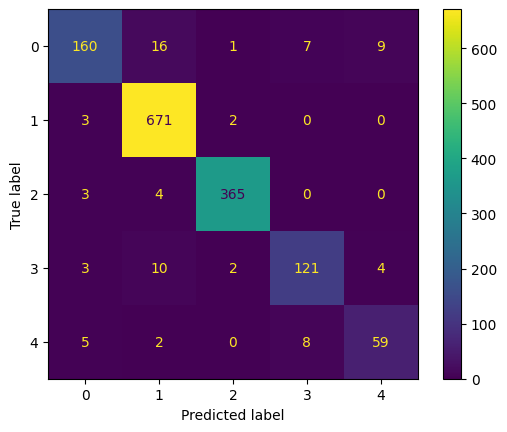

In [13]:
acc = (y_pred.argmax(axis=1) == y_val).mean()
print("\nValidation Accuracy: {:.3f} %".format(acc)) # Testing Accuracy: 82.963 %

clf_classes = list(range(5))
cm = confusion_matrix(y_val, y_pred.argmax(axis=1), labels=clf_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_classes)
print(dict_map_labels)
disp.plot();

In [14]:
df_test = pd.DataFrame({'filename': filenames})

df_test["butterfly_id"] = df_test["filename"].apply(lambda f: f.split("/")[-1].split("_")[0])
print(df_test.shape)

view_rows = df_labels["subspecies"].isna()

df_test = pd.merge(df_test, df_labels[view_rows][view_cols], on="butterfly_id")
df_test.tail()

X_test = []
for index, row in tqdm(df_test.iterrows()):
    img = get_features_row(row)
    X_test.append(img.flatten())
    
X_test = np.stack(X_test)
print(X_test.shape)
df_test.tail()

(7598, 2)


357it [00:00, 8124.35it/s]

(357, 512)


,filename,butterfly_id,hybrid_stat,subspecies
352,sub_images/positive/CAM016793_2.jpg,CAM016793,hybrid,NaN
353,sub_images/positive/CAM016784_3.jpg,CAM016784,hybrid,NaN
354,sub_images/positive/CAM016794_0.jpg,CAM016794,hybrid,NaN
355,sub_images/positive/CAM016980_1.jpg,CAM016980,hybrid,NaN
356,sub_images/positive/CAM016852_3.jpg,CAM016852,hybrid,NaN


In [15]:
y_pred = model.predict_proba(X_test)
y_pred.shape

df_show = df_test.copy()
for i in range(5):
    df_show[i] = y_pred[:,i]
    
df_show["pred"] = y_pred.argmax(axis=1)
print(df_show["pred"].value_counts())

# 1    3352
# 2    1871
# 0     904
# 3     736
# 4     378

df_show["prob"] = y_pred.max(axis=1)
df_show

Slicing Images...
Slicing Images...
pred
1    331
3     13
0     11
4      2
Name: count, dtype: int64


,filename,butterfly_id,hybrid_stat,subspecies,0,1,2,3,4,pred,prob
0,sub_images/positive/CAM016787_3.jpg,CAM016787,hybrid,NaN,0.005658,0.994342,0.000000,0.000000,0.000000,1,0.994342
1,sub_images/positive/CAM016784_1.jpg,CAM016784,hybrid,NaN,0.059765,0.898423,0.006447,0.012801,0.022564,1,0.898423
2,sub_images/positive/CAM017984_1.jpg,CAM017984,hybrid,NaN,0.031007,0.944043,0.005946,0.013614,0.005390,1,0.944043
3,sub_images/positive/CAM016667_2.jpg,CAM016667,hybrid,NaN,0.001800,0.997300,0.000000,0.000000,0.000900,1,0.997300
4,sub_images/positive/CAM018327_2.jpg,CAM018327,hybrid,NaN,0.288987,0.556320,0.036893,0.076259,0.041541,1,0.556320
...,...,...,...,...,...,...,...,...,...,...,...
352,sub_images/positive/CAM016793_2.jpg,CAM016793,hybrid,NaN,0.056320,0.885107,0.010058,0.031777,0.016737,1,0.885107
353,sub_images/positive/CAM016784_3.jpg,CAM016784,hybrid,NaN,0.001650,0.997643,0.000000,0.000000,0.000707,1,0.997643
354,sub_images/positive/CAM016794_0.jpg,CAM016794,hybrid,NaN,0.173749,0.658734,0.070594,0.054523,0.042401,1,0.658734
355,sub_images/positive/CAM016980_1.jpg,CAM016980,hybrid,NaN,0.119510,0.696055,0.090037,0.048091,0.046307,1,0.696055


In [16]:
df_p1 = df_show.copy()

In [17]:
df_show_agg = df_show.groupby("butterfly_id")["prob"].agg(["mean", "std"])
df_show_agg

,mean,std
butterfly_id,,
CAM016049,0.833912,0.270357
CAM016051,0.957228,0.034699
CAM016052,0.737053,0.104803
CAM016053,0.946319,0.043035
CAM016054,0.962132,0.060431
...,...,...
CAM018252,0.692936,0.354281
CAM018270,0.949617,0.047397
CAM018304,0.743572,0.180740


STD - Validation set 
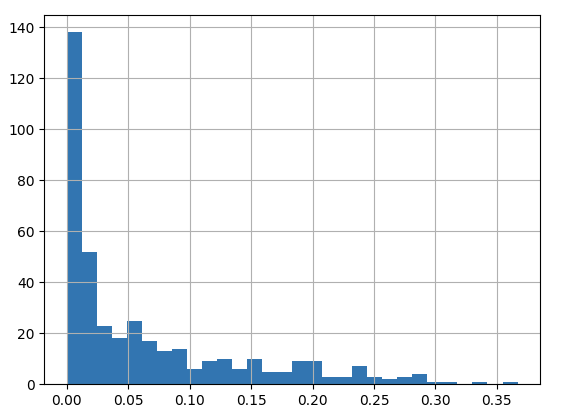

<Axes: >

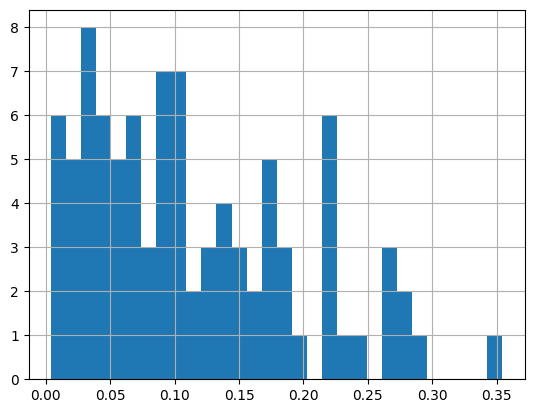

In [18]:
df_show_agg["std"].hist(bins=30)

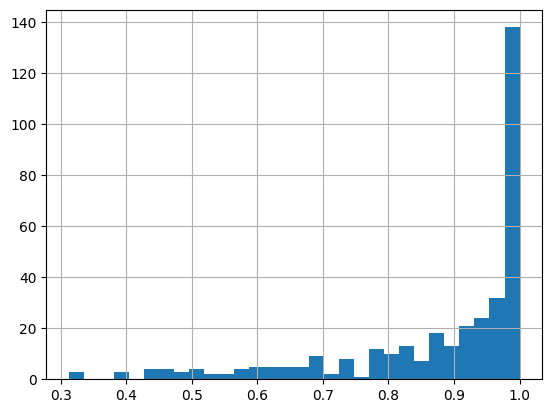

In [19]:
df_show["prob"].hist(bins=30);

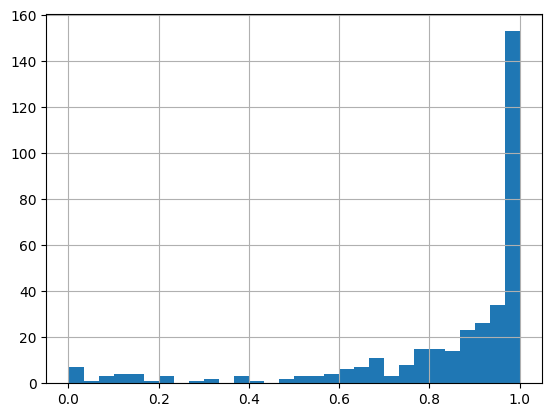

In [20]:
df_show[1].hist(bins=30);

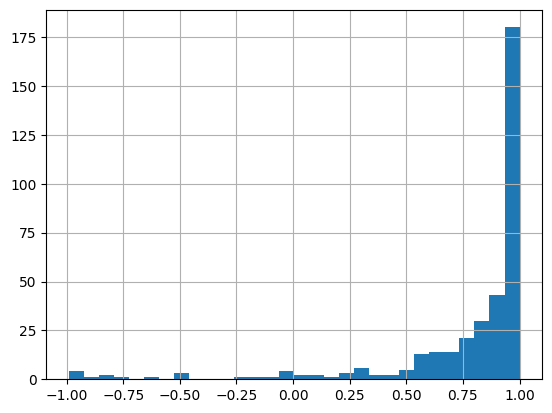

In [21]:
(df_show[1]-df_show[3]).hist(bins=30);

In [22]:
dict_models[0].keys()

fold = 0
df_show = dict_models[fold]["df_val"] # dict_keys(['model', 'metrics', 'y_pred', 'y_val', 'df_val'])
df_show["pred"] = dict_models[fold]["y_pred"].argmax(axis=1)
df_show["prob"] = dict_models[fold]["y_pred"].max(axis=1)
for i in range(5):
    df_show[i] = dict_models[fold]["y_pred"][:,i]
df_show

,filename,butterfly_id,hybrid_stat,subspecies,label,fold,pred,prob,0,1,2,3,4
0,sub_images/positive/19N2282_3.jpg,19N2282,non-hybrid,8.0,1,0,1,0.997383,0.002617,0.997383,0.000000,0.000000,0.000000
1,sub_images/positive/19N2117_0.jpg,19N2117,non-hybrid,8.0,1,0,1,0.983333,0.005569,0.983333,0.004538,0.004950,0.001609
2,sub_images/positive/CAM016831_2.jpg,CAM016831,non-hybrid,9.0,3,0,3,0.648235,0.145944,0.059703,0.097947,0.648235,0.048171
3,sub_images/positive/CAM040572_0.jpg,CAM040572,non-hybrid,2.0,2,0,2,0.968022,0.012404,0.004084,0.968022,0.008575,0.006915
4,sub_images/positive/CAM040236_3.jpg,CAM040236,non-hybrid,8.0,1,0,1,0.989463,0.008062,0.989463,0.002475,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,sub_images/positive/CAM008963_3.jpg,CAM008963,non-hybrid,7.0,4,0,4,0.478397,0.269780,0.033972,0.025611,0.192240,0.478397
1451,sub_images/positive/CAM000207_2.jpg,CAM000207,non-hybrid,1.0,0,0,0,0.732001,0.732001,0.101353,0.067642,0.047324,0.051680
1452,sub_images/positive/CAM041585_2.jpg,CAM041585,non-hybrid,8.0,1,0,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1453,sub_images/positive/19N2241_2.jpg,19N2241,non-hybrid,8.0,1,0,1,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [23]:
df_p2 = df_show.copy()

In [24]:
selected_rows = (df_show["subspecies"] == "8.0") | (df_show["subspecies"] == 8.0)
print(df_show[selected_rows].shape)

df_show_agg = df_show[selected_rows].groupby("butterfly_id")["pred"].nunique()
df_show_agg.value_counts()

df_show_agg = df_show.groupby("butterfly_id")["prob"].agg(["mean", "std"])
df_show_agg

(676, 13)


,mean,std
butterfly_id,,
18N0614,0.998762,0.002475
19N0006,1.000000,0.000000
19N0011,0.979225,0.034866
19N0020,0.994330,0.006680
19N0021,0.996586,0.006828
...,...,...
F935,0.945772,0.039635
F963,0.984889,0.011302
F974,0.988003,0.006621


<Axes: >

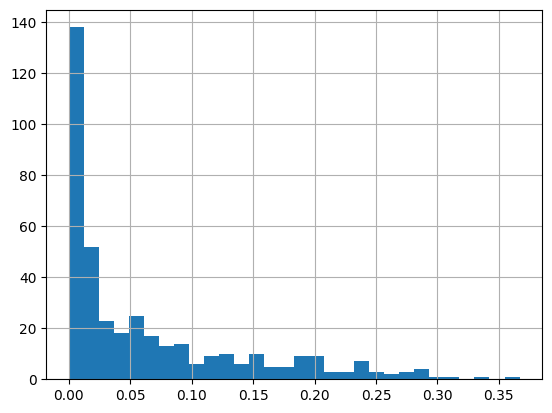

In [25]:
df_show_agg["std"].hist(bins=30)

In [26]:
df_train

,filename,butterfly_id,hybrid_stat,subspecies,label
0,sub_images/positive/19N2282_3.jpg,19N2282,non-hybrid,8.0,1
1,sub_images/positive/19N2117_0.jpg,19N2117,non-hybrid,8.0,1
2,sub_images/positive/CS000283_1.jpg,CS000283,non-hybrid,13.0,0
3,sub_images/positive/CAM040497_1.jpg,CAM040497,non-hybrid,2.0,2
4,sub_images/positive/19N0053_2.jpg,19N0053,non-hybrid,8.0,1
...,...,...,...,...,...
7236,sub_images/positive/CAM021071_2.jpg,CAM021071,non-hybrid,0.0,0
7237,sub_images/positive/19N2159_1.jpg,19N2159,non-hybrid,8.0,1
7238,sub_images/positive/CAM041069_1.jpg,CAM041069,non-hybrid,8.0,1
7239,sub_images/positive/CAM008980_0.jpg,CAM008980,non-hybrid,7.0,4


In [27]:
# df_show = pd.concat([df_p1, df_p2]).reset_index(drop=True)
df_show = pd.concat([df_p1, df_p2]).reset_index(drop=True)
df_show["label"] = df_show["label"].fillna(-1).astype(int)
print(df_p1.shape, df_p2.shape)
df_show

(357, 11) (1455, 13)


,filename,butterfly_id,hybrid_stat,subspecies,0,1,2,3,4,pred,prob,label,fold
0,sub_images/positive/CAM016787_3.jpg,CAM016787,hybrid,NaN,0.005658,0.994342,0.000000,0.000000,0.000000,1,0.994342,-1,NaN
1,sub_images/positive/CAM016784_1.jpg,CAM016784,hybrid,NaN,0.059765,0.898423,0.006447,0.012801,0.022564,1,0.898423,-1,NaN
2,sub_images/positive/CAM017984_1.jpg,CAM017984,hybrid,NaN,0.031007,0.944043,0.005946,0.013614,0.005390,1,0.944043,-1,NaN
3,sub_images/positive/CAM016667_2.jpg,CAM016667,hybrid,NaN,0.001800,0.997300,0.000000,0.000000,0.000900,1,0.997300,-1,NaN
4,sub_images/positive/CAM018327_2.jpg,CAM018327,hybrid,NaN,0.288987,0.556320,0.036893,0.076259,0.041541,1,0.556320,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,sub_images/positive/CAM008963_3.jpg,CAM008963,non-hybrid,7.0,0.269780,0.033972,0.025611,0.192240,0.478397,4,0.478397,4,0.0
1808,sub_images/positive/CAM000207_2.jpg,CAM000207,non-hybrid,1.0,0.732001,0.101353,0.067642,0.047324,0.051680,0,0.732001,0,0.0
1809,sub_images/positive/CAM041585_2.jpg,CAM041585,non-hybrid,8.0,0.000000,1.000000,0.000000,0.000000,0.000000,1,1.000000,1,0.0
1810,sub_images/positive/19N2241_2.jpg,19N2241,non-hybrid,8.0,0.000000,1.000000,0.000000,0.000000,0.000000,1,1.000000,1,0.0


In [28]:
df_show_agg = df_show.groupby("butterfly_id")\
    .agg({1:['max','mean','std'], 2:['max','mean','std'], 3:['max','mean','std'], "pred": ["nunique"], "label": ["mean"]})
df_show_agg

1                             2                      \
                   max      mean       std       max      mean       std   
butterfly_id                                                               
18N0614       1.000000  0.998762  0.002475  0.000000  0.000000  0.000000   
19N0006       1.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
19N0011       1.000000  0.979225  0.034866  0.033116  0.009929  0.015768   
19N0020       1.000000  0.994330  0.006680  0.005776  0.001719  0.002754   
19N0021       1.000000  0.996586  0.006828  0.000000  0.000000  0.000000   
...                ...       ...       ...       ...       ...       ...   
F935          0.034418  0.023397  0.015586  0.020586  0.014607  0.008455   
F963          0.009763  0.007357  0.003403  0.009488  0.004744  0.006709   
F974          0.012251  0.007363  0.006913  0.002888  0.001719  0.001653   
F995          0.013201  0.011851  0.001909  0.009605  0.007278  0.003291   
F998          0.011021  0.008536  0.003514  0.001238  0.001169  0.000097   

                     3                        pred label  
                   max      mean       std nunique  mean  
butterfly_id                                              
18N0614       0.004950  0.001238  0.002475       1   1.0  
19N0006       0.000000  0.000000  0.000000       1   1.0  
19N0011       0.007603  0.002643  0.003591       1   1.0  
19N0020       0.001650  0.000413  0.000825       1   1.0  
19N0021       0.002475  0.000619  0.001238       1   1.0  
...                ...       ...       ...     ...   ...  
F935          0.014916  0.009748  0.007309       1   0.0  
F963          0.003850  0.002235  0.002285       1   0.0  
F974          0.003300  0.001925  0.001945       1   0.0  
F995          0.001619  0.001084  0.000756       1   0.0  
F998          0.001169  0.000894  0.000389       1   0.0  

[490 rows x 11 columns]

In [29]:
df_show_agg["std"] = df_show_agg[[(      1,     'std'), (      2,     'std'), (      3,     'std')]].mean(axis=1)
df_show_agg

1                             2                      \
                   max      mean       std       max      mean       std   
butterfly_id                                                               
18N0614       1.000000  0.998762  0.002475  0.000000  0.000000  0.000000   
19N0006       1.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
19N0011       1.000000  0.979225  0.034866  0.033116  0.009929  0.015768   
19N0020       1.000000  0.994330  0.006680  0.005776  0.001719  0.002754   
19N0021       1.000000  0.996586  0.006828  0.000000  0.000000  0.000000   
...                ...       ...       ...       ...       ...       ...   
F935          0.034418  0.023397  0.015586  0.020586  0.014607  0.008455   
F963          0.009763  0.007357  0.003403  0.009488  0.004744  0.006709   
F974          0.012251  0.007363  0.006913  0.002888  0.001719  0.001653   
F995          0.013201  0.011851  0.001909  0.009605  0.007278  0.003291   
F998          0.011021  0.008536  0.003514  0.001238  0.001169  0.000097   

                     3                        pred label       std  
                   max      mean       std nunique  mean            
butterfly_id                                                        
18N0614       0.004950  0.001238  0.002475       1   1.0  0.001650  
19N0006       0.000000  0.000000  0.000000       1   1.0  0.000000  
19N0011       0.007603  0.002643  0.003591       1   1.0  0.018075  
19N0020       0.001650  0.000413  0.000825       1   1.0  0.003420  
19N0021       0.002475  0.000619  0.001238       1   1.0  0.002688  
...                ...       ...       ...     ...   ...       ...  
F935          0.014916  0.009748  0.007309       1   0.0  0.010450  
F963          0.003850  0.002235  0.002285       1   0.0  0.004133  
F974          0.003300  0.001925  0.001945       1   0.0  0.003503  
F995          0.001619  0.001084  0.000756       1   0.0  0.001986  
F998          0.001169  0.000894  0.000389       1   0.0  0.001334  

[490 rows x 12 columns]

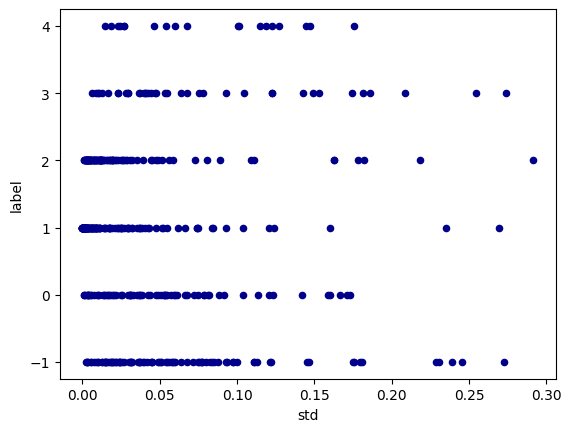

In [30]:
df_show_agg.plot.scatter(x='std',
                         y='label',
                         c='DarkBlue');

In [31]:
selected_rows = df_show["pred"].isin([1,2,3])

df_show_agg = df_show[selected_rows].groupby("butterfly_id")\
    .agg({'prob':['max','mean','std'], "pred": ["nunique"], "label": ["mean"]})
df_show_agg.columns = ["max_prob", "mean_prob", "std_prob", "nunique", "label"]

df_show_agg = df_show_agg.reset_index()
df_show_agg = pd.merge(df_show[["butterfly_id", "label"]].drop_duplicates(),
                       df_show_agg.drop(columns=["label"]),
                        on="butterfly_id", how="left")
df_show_agg = df_show_agg.fillna(0)
df_show_agg["label"] = df_show_agg["label"].astype(int)
df_show_agg["nunique"] = df_show_agg["nunique"].astype(int)
df_show_agg

,butterfly_id,label,max_prob,mean_prob,std_prob,nunique
0,CAM016787,-1,0.994342,0.965668,0.034711,1
1,CAM016784,-1,1.000000,0.876062,0.184754,1
2,CAM017984,-1,0.944043,0.898120,0.045054,1
3,CAM016667,-1,0.999175,0.956269,0.078555,1
4,CAM018327,-1,0.972896,0.748048,0.175163,1
...,...,...,...,...,...,...
485,CAM040587,2,0.999293,0.982408,0.028771,1
486,CAM036388,0,0.000000,0.000000,0.000000,0
487,F1018,0,0.000000,0.000000,0.000000,0
488,CS000278,0,0.000000,0.000000,0.000000,0


In [32]:
df_show_agg.groupby(["label", "nunique"])["label"].count()

label  nunique
-1     1           86
       2            5
 0     0           58
       1           14
 1     1          170
       2            2
 2     1           94
       2            3
 3     1           36
       2            3
 4     0           10
       1            9
Name: label, dtype: int64

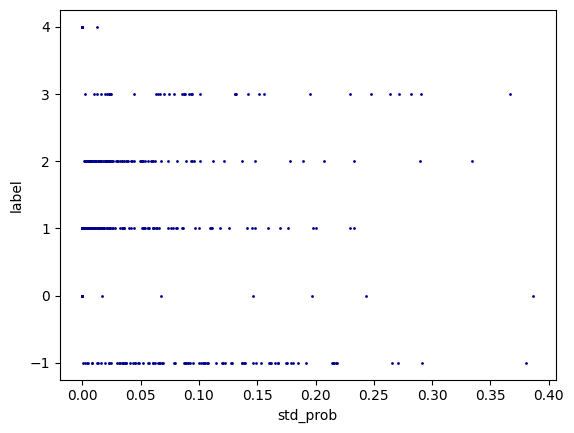

In [33]:
df_show_agg.plot.scatter(x='std_prob',
                         y='label',
                         c='DarkBlue', s=1);

In [34]:
def duplicate_neg(df, nb_dup=5):
    df_pos = df[df["label"] == -1]
    df_neg = df[df["label"] >= 0]
    arr = [df_pos]
    for i in range(nb_dup):
        arr.append(df_neg)
    
    df_out = pd.concat(arr).reset_index(drop=True)
    return df_out

df_out = duplicate_neg(df_show_agg)
df_out

,butterfly_id,label,max_prob,mean_prob,std_prob,nunique
0,CAM016787,-1,0.994342,0.965668,0.034711,1
1,CAM016784,-1,1.000000,0.876062,0.184754,1
2,CAM017984,-1,0.944043,0.898120,0.045054,1
3,CAM016667,-1,0.999175,0.956269,0.078555,1
4,CAM018327,-1,0.972896,0.748048,0.175163,1
...,...,...,...,...,...,...
2081,CAM040587,2,0.999293,0.982408,0.028771,1
2082,CAM036388,0,0.000000,0.000000,0.000000,0
2083,F1018,0,0.000000,0.000000,0.000000,0
2084,CS000278,0,0.000000,0.000000,0.000000,0


In [35]:
rs = evaluate(scores=df_out["std_prob"], labels=(df_out["label"]==-1).astype(int))
rs

(np.float64(0.10989010989010989),
 np.float64(0.09174311926605505),
 np.float64(0.1),
 np.float64(0.530133024869867),
 0.9137104506232023)

In [36]:
# Your algorithm needs to generate an anomaly score for each input image: the higher the score is, 
# the more likely the input image is an anomaly (i.e., hybrid).

# The submissions are evaluated based on two metrics:
# - The true positive rate (TPR) at the true negative rate (TNR) = 95%: 
# the recall of hybrid cases, with a score threshold set to recognizing non-hybrid cases with 95% accuracy.
# - PRC AUC
                                                 
print_evaluation(*rs)


          Hybrid-Recall: 0.10989010989010989
          Hybrid-Precision: 0.09174311926605505
          f1-Score: 0.1
          ROC AUC: 0.530133024869867
          Accuracy: 0.9137104506232023
          


In [38]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def cal_pr_auc(gt, preds):
    precision, recall, _ = precision_recall_curve(gt, preds)
    pr_auc = auc(recall, precision)
    return float(pr_auc)
    
def evaluate_prediction(scores, labels, reversed=False):
    combined = list(zip(scores, labels))
    combined = sorted(combined, key=lambda x: x[0], reverse=reversed)
    combined = np.array(combined)

    for i in range(combined.shape[0] + 1):
        ls, rs = i, combined.shape[0] - i
        preds = np.concatenate((np.zeros(ls), np.ones(rs)))
        recall = recall_score(combined[:, 1], preds, pos_label=0)
        if recall >= 0.95:
            return preds, combined[:, 1]
    
    return None, combined[:, 1]  

def evaluate(scores, labels, reversed=False):
    """Requires lower score to mean more likely to be non-hybrid,
    and higher score to mean more likely to be hybrid.
    
    If you would like this to be reversed, set reversed=True
    """
    preds, gt = evaluate_prediction(scores, labels, reversed)

    if preds is None:
        return None  
    
    h_recall = recall_score(gt, preds, pos_label=1)
    h_precision = precision_score(gt, preds, pos_label=1)
    f1 = f1_score(gt, preds, pos_label=1)
    roc_auc = roc_auc_score(gt, preds)
    acc = accuracy_score(gt, preds)

    pr_auc = cal_pr_auc(gt, preds)

    return h_recall, h_precision, f1, roc_auc, acc, pr_auc

def print_evaluation(h_recall, h_precision, f1, roc_auc, acc, pr_auc):
    print(f"""
          Hybrid-Recall: {h_recall}
          Hybrid-Precision: {h_precision}
          f1-Score: {f1}
          ROC AUC: {roc_auc}
          Accuracy: {acc},
          PR AUC: {pr_auc}
          """)

In [39]:
cal_pr_auc(gt=(df_out["label"]==-1).astype(int), preds=df_out["std_prob"])

0.11799671967359551

# Save

In [40]:
dict_model_submission = {
    "model": dict_models[0]["model"]
}

with open('workspace/butterfly_models_5cls.pickle', 'wb') as handle:
    pickle.dump(dict_model_submission, handle)

In [41]:
dict_models[0].keys(), type(dict_models[0]["model"])

(dict_keys(['model', 'metrics', 'y_pred', 'y_val', 'df_val']),
 GCForest.gcForest)

In [42]:
import sklearn
import transformers
sklearn.__version__, transformers.__version__

('1.4.2', '4.48.0')

In [43]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('2.3.0+cu121', '0.18.0+cu121')